In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# will convert PIL images into tensors, and normalize pixel values
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((.5,), (.5))
])

mnist_train = datasets.MNIST('./data/', train=True, transform=transform)
mnist_test = datasets.MNIST('./data/', train=False, transform=transform)

In [2]:
tdev = (
  'cuda' if torch.cuda.is_available()
  else 'mps' if torch.backends.mps.is_available()
  else 'cpu'
)

print(f'Using {tdev} device')

Using mps device


In [3]:
import torch.utils.data as data

train_dl = data.DataLoader(mnist_train, batch_size=64, shuffle=True) 
test_dl = data.DataLoader(mnist_test, batch_size=64, shuffle=True) 

In [4]:
xb, yb = iter(train_dl).__next__()

xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [ ]:
cnn = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
cnn(xb).shape

In [ ]:
cnn2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
cnn2(cnn(xb)).shape

In [ ]:
class GPTConvNet(torch.nn.Module):
  def __init__(self) -> None:
    super(GPTConvNet, self).__init__()
    
    self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.fc1 = torch.nn.Linear(64*28*28, 128)
    self.fc2 = torch.nn.Linear(128, 10)
    self.relu = torch.nn.ReLU()
    
  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = x.view(-1, 64*28*28)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    
    return x

In [5]:
def train(model: torch.nn.Module, dls: tuple[data.DataLoader, data.DataLoader], n_epochs=5, lr=1e-3,
          criterion=torch.nn.CrossEntropyLoss(), optimizer=torch.optim.SGD):
  model.to(tdev)
  optim = optimizer(model.parameters(), lr=lr)
  train_dl, test_dl = dls
  
  for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_dl:
      xb, yb = xb.to(tdev), yb.to(tdev)
      
      outputs = model(xb)
      loss = criterion(outputs, yb)
      
      optim.zero_grad()
      loss.backward()
      optim.step()
      
      running_loss += loss.item()
      
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
      for xvb, yvb in test_dl:
        xvb, yvb = xvb.to(tdev), yvb.to(tdev)
        
        outputs = model(xvb)
        _, pred = torch.max(outputs, 1)
        total += yvb.size(0)
        correct += (pred == yvb).sum().item()
      
    print(f'Epoch [{epoch+1}], Loss: {running_loss / len(train_dl):.4f}, Accuracy(test): {100*correct/total:.2f}%')
      
      

In [ ]:
model = GPTConvNet()

In [ ]:
model.conv1.weight.shape

In [ ]:
model.conv1.bias.shape

In [ ]:
model.conv2.weight.shape

In [ ]:
model.conv2.bias.shape

In [ ]:
train(model, (train_dl, test_dl))

In [ ]:
model2 = GPTConvNet()

train(model2, (train_dl, test_dl), optimizer=torch.optim.Adam)

In [6]:
class SimpleConvNet(torch.nn.Module):
  def __init__(self) -> None:
    super(SimpleConvNet, self).__init__()
    
    self.layer1 = torch.nn.Sequential(
      torch.nn.Conv2d(1, 16, stride=2, padding=3, kernel_size=7),
      torch.nn.ReLU(),
    )
    self.layer2 = torch.nn.Sequential(
      torch.nn.Conv2d(16, 32, stride=2, padding=1, kernel_size=3),
      torch.nn.ReLU(),
    )
    self.layer3 = torch.nn.Sequential(
      torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
      torch.nn.ReLU(),
    )
    self.layer4 = torch.nn.Sequential(
      torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
      torch.nn.ReLU()
    )
    self.layer5 = torch.nn.Sequential(
      torch.nn.Conv2d(128, 10, kernel_size=3, stride=2, padding=1),
      torch.nn.Flatten()
    )
    
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    
    return x

In [ ]:
model3 = SimpleConvNet()

train(model3, (train_dl, test_dl))

In [ ]:
model4 = SimpleConvNet()

train(model4, (train_dl, test_dl), optimizer=torch.optim.Adam)

In [ ]:
model5 = SimpleConvNet()

train(model5, (train_dl, test_dl), optimizer=torch.optim.Adam, lr=5e-2)

In [ ]:
model5(xb.to(tdev)).shape

In [ ]:
model5.layer1(xb.to(tdev)).shape

In [7]:
from collections import defaultdict

def get_activation_stats(name, stats: dict[str, dict[str, list]]):
  def hook(model, input, output: torch.Tensor):
    mean = output.data.mean()
    std = output.data.std()
    zero = (output.abs() < 1e-2).float().mean() * 100
    stats[name]["mean"].append(mean.item())  
    stats[name]["std"].append(std.item())
    stats[name]["zero"].append(zero.item())
    
  return hook
 
def add_activation_stats(model: torch.nn.Module):
  stats = defaultdict(lambda: {"mean": [], "std": [], "zero": []})
  
  for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
      layer.register_forward_hook(get_activation_stats(name, stats))
  
  return stats

In [ ]:
model6 = SimpleConvNet()

In [ ]:
activation_stats = add_activation_stats(model6)

In [ ]:
train(model6, (train_dl, test_dl), optimizer=torch.optim.Adam, lr=5e-2)

In [8]:
import matplotlib.pyplot as plt

def plot_activation_stats(stats):
  for layer, data in stats.items():
    epochs = range(len(data["mean"]))
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, data["mean"], label="mean")
    plt.title(f"Layer: {layer} - Mean Activation")
    plt.ylabel("Mean")
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, data["std"], label="std")  
    plt.title(f"Layer: {layer} - Standard Deviation")
    plt.ylabel("std")
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, data["zero"], label="% near zero")
    plt.title(f"Layer: {layer} - % near Zero")
    plt.ylabel("% near zero")
    plt.legend()
    
    plt.show()

In [ ]:
plot_activation_stats(activation_stats)

In [ ]:
model7 = SimpleConvNet()

train_dl_512 = data.DataLoader(mnist_train, batch_size=512, shuffle=True)
test_dl_512 = data.DataLoader(mnist_test, batch_size=512, shuffle=True)

dl_512 = (train_dl_512, test_dl_512)

m7_stats = add_activation_stats(model7)

train(model7, dl_512, optimizer=torch.optim.Adam, lr=5e-2)

In [ ]:
plot_activation_stats(m7_stats)

In [9]:
model8 = SimpleConvNet()

train_dl_1024 = data.DataLoader(mnist_train, batch_size=1024, shuffle=True)
test_dl_1024 = data.DataLoader(mnist_test, batch_size=1024, shuffle=True)

dl_1024 = (train_dl_1024, test_dl_1024)

m8_stats = add_activation_stats(model8)

train(model8, dl_1024, optimizer=torch.optim.Adam, lr=5e-2)

Epoch [1], Loss: 3.3579, Accuracy(test): 11.35%
Epoch [2], Loss: 2.3022, Accuracy(test): 11.35%
Epoch [3], Loss: 2.3018, Accuracy(test): 11.35%
Epoch [4], Loss: 2.3023, Accuracy(test): 11.35%
Epoch [5], Loss: 2.3019, Accuracy(test): 11.35%


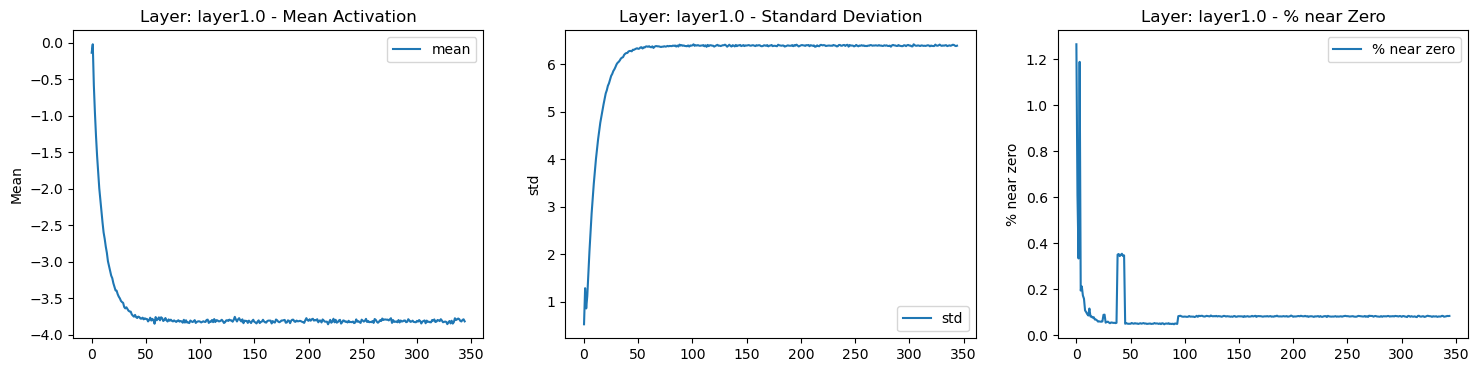

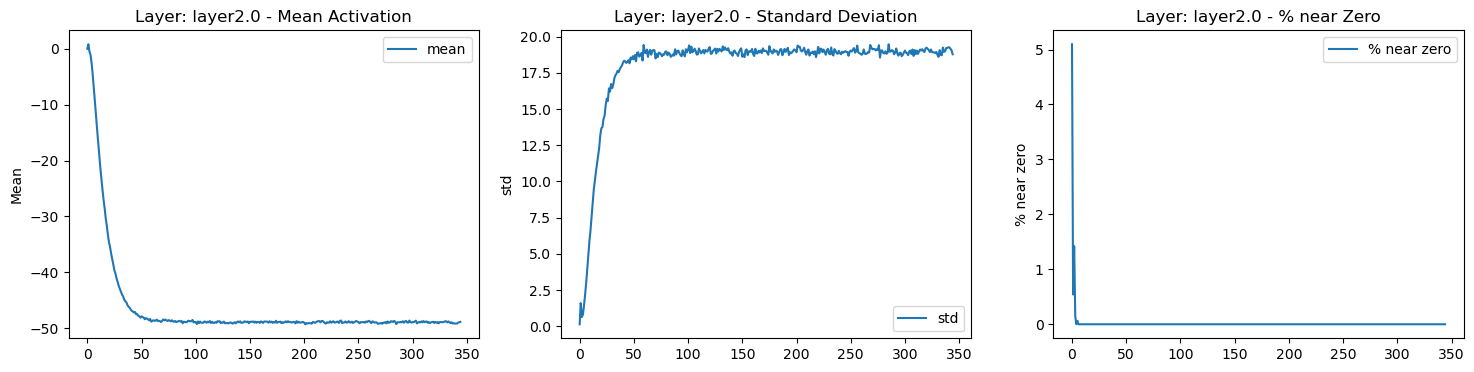

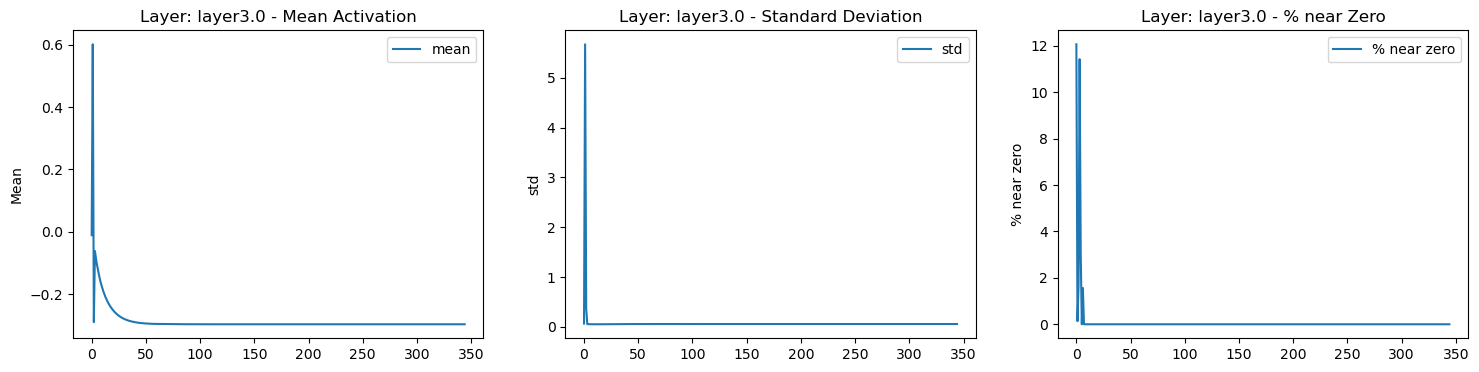

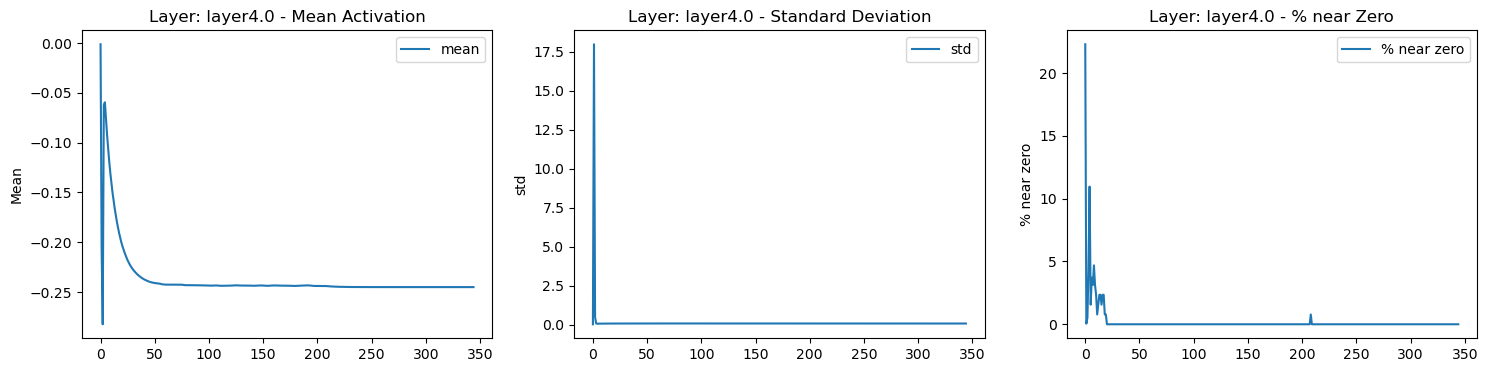

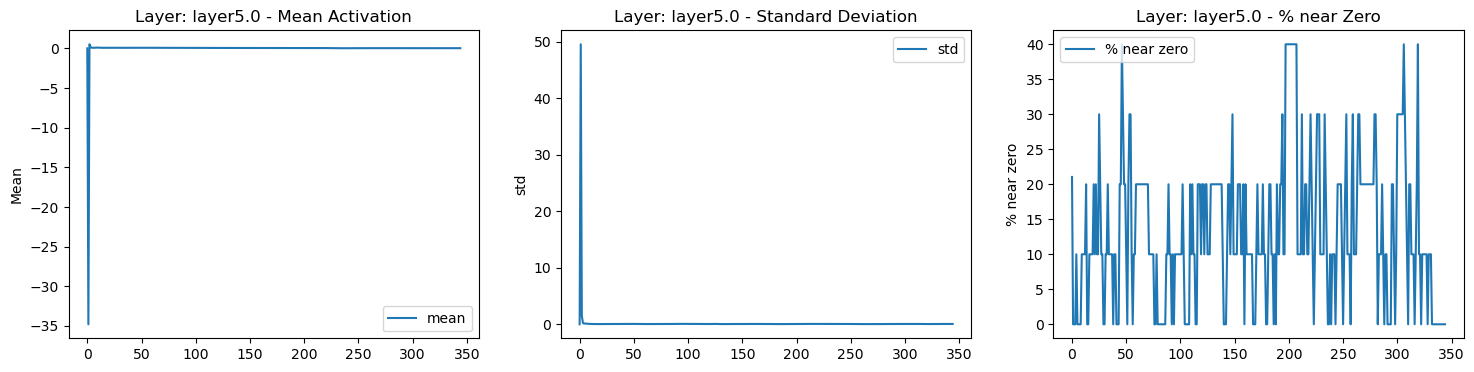

In [10]:
plot_activation_stats(m8_stats)

In [61]:
optim_state = []

In [62]:
import torch.optim.lr_scheduler as lr_scheduler

def train_one_cycle(model: torch.nn.Module, dls: tuple[data.DataLoader, data.DataLoader], n_epochs=5, lr=1e-3,
                    optim=torch.optim.SGD, criterion=torch.nn.CrossEntropyLoss(), record=False):
  model.to(tdev)
  optim = optim(model.parameters(), lr=lr)
  train_dl, test_dl = dls
  scheduler = lr_scheduler.OneCycleLR(optim, max_lr=1e-1, total_steps=n_epochs*len(train_dl))
  
  if record: 
    optim_state.clear()
  
  for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_dl:
      xb, yb = xb.to(tdev), yb.to(tdev)
      
      outputs = model(xb)
      loss = criterion(outputs, yb)
      
      optim.zero_grad()
      loss.backward()
      optim.step()
      
      if record: 
        optim_state.append(optim.state_dict()['param_groups'][0]['lr'])
        
      scheduler.step()
      running_loss += loss.item()
      
    model.eval()
    total = 0
    correct = 0
    v_loss = 0.0
    with torch.no_grad():
      for xvb, yvb in test_dl:
        xvb, yvb = xvb.to(tdev), yvb.to(tdev)
        
        outputs = model(xvb)
        loss = criterion(outputs, yvb)
        _, pred = torch.max(outputs, 1)
        total += yvb.size(0)
        correct += (pred == yvb).sum().item()
        v_loss += loss.item()
      
    print(f'Epoch[{epoch+1}] | Training Loss: {running_loss / len(train_dl):.4f}, Validation Loss: {v_loss / len(test_dl):.4f}, Accuracy(test): {100*correct/total:.2f}%')

In [63]:
train_one_cycle(SimpleConvNet(), dl_1024, n_epochs=2, lr=5e-2, record=True)

Epoch[1] | Training Loss: 2.3331, Validation Loss: 2.1551, Accuracy(test): 19.85%
Epoch[2] | Training Loss: 1.0277, Validation Loss: 0.4543, Accuracy(test): 86.49%


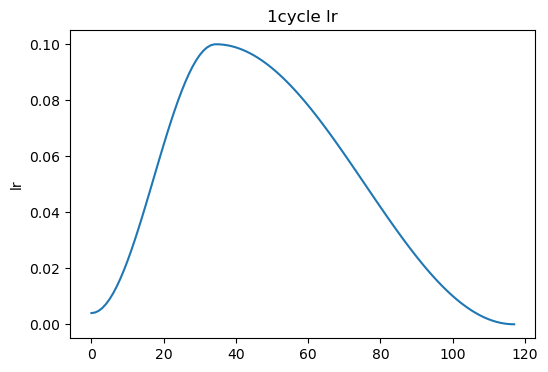

In [64]:
plt.figure(figsize=(6,4))

plt.plot(range(len(optim_state)), optim_state, label="lr")
plt.title("1cycle lr")
plt.ylabel("lr")
plt.show()

In [67]:
class ConvNet(torch.nn.Module):
  def __init__(self) -> None:
    super(ConvNet, self).__init__()
    
    self.layer1 = torch.nn.Sequential(
      torch.nn.Conv2d(1, 32, stride=2, padding=3, kernel_size=7),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(32)
    )
    self.layer2 = torch.nn.Sequential(
      torch.nn.Conv2d(32, 64, stride=2, padding=1, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(64)
    )
    self.layer3 = torch.nn.Sequential(
      torch.nn.Conv2d(64, 128, stride=2, padding=1, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(128),
    )
    self.layer4 = torch.nn.Sequential(
      torch.nn.Conv2d(128, 10, stride=2, padding=1, kernel_size=3),
      torch.nn.BatchNorm2d(10)
    )
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = torch.nn.Flatten()(x)
    
    return x

In [68]:
train_one_cycle(ConvNet(), dl_1024, n_epochs=2, lr=5e-2)

Epoch[1] | Training Loss: 0.8431, Validation Loss: 0.1313, Accuracy(test): 96.10%
Epoch[2] | Training Loss: 0.1112, Validation Loss: 0.1010, Accuracy(test): 96.94%


In [69]:
cnn = ConvNet()

activation_stats = add_activation_stats(cnn)

train_one_cycle(cnn, dl_1024, n_epochs=2, lr=5e-2)

Epoch[1] | Training Loss: 0.8597, Validation Loss: 0.1486, Accuracy(test): 95.33%
Epoch[2] | Training Loss: 0.1147, Validation Loss: 0.1043, Accuracy(test): 96.66%


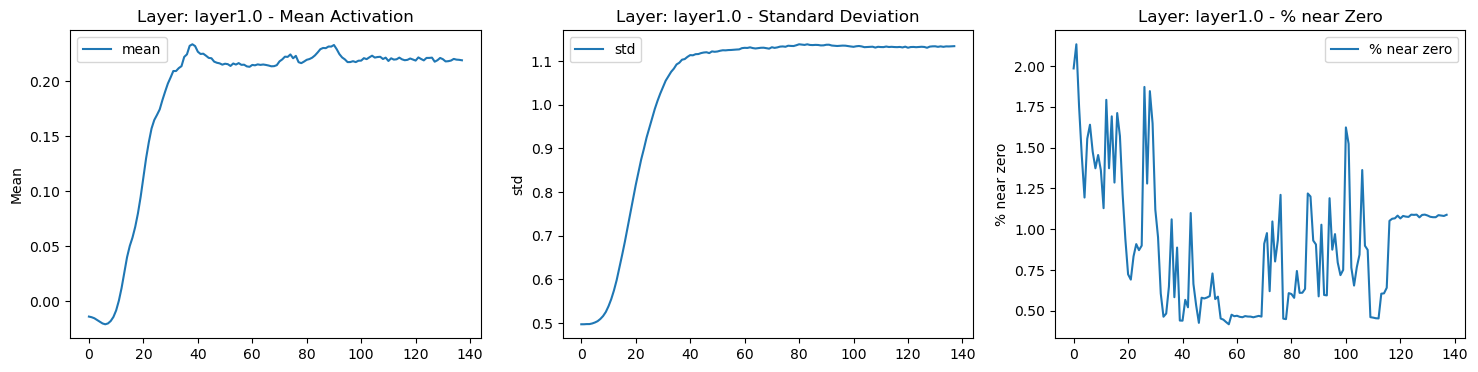

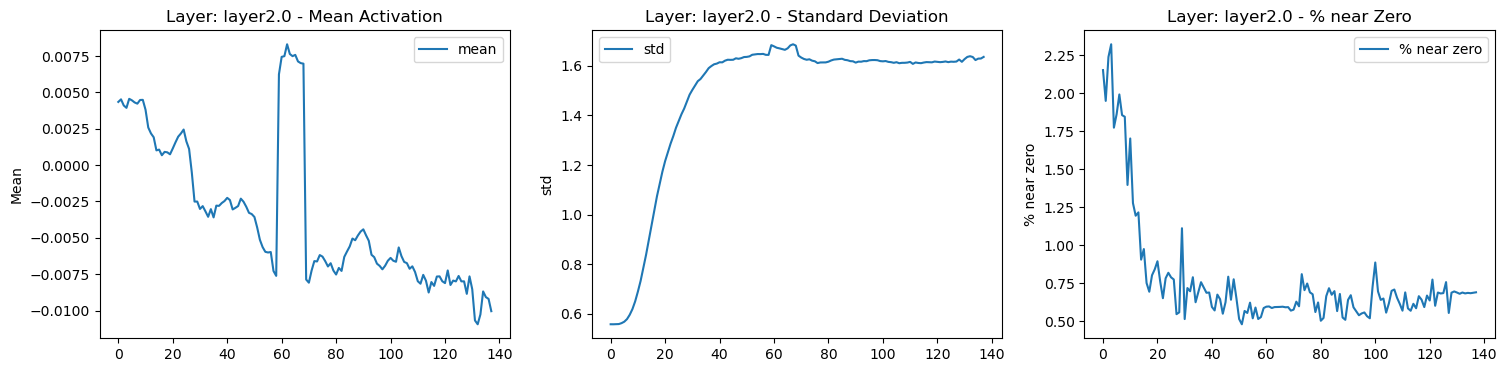

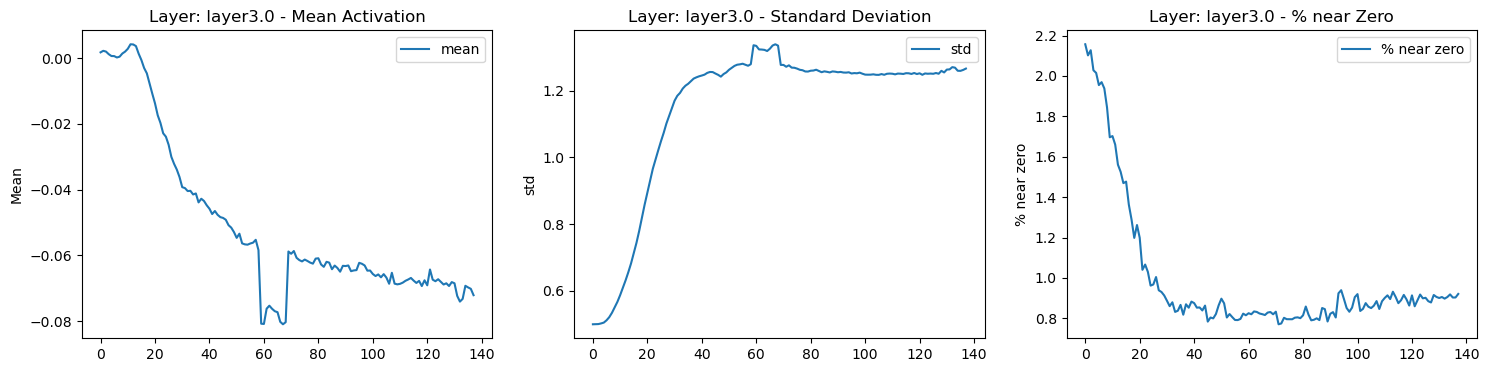

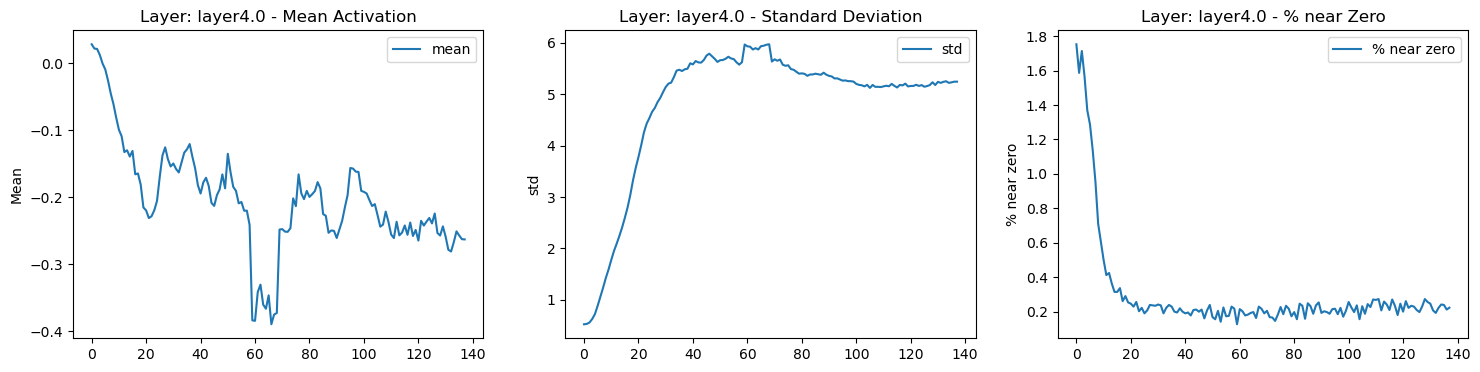

In [70]:
plot_activation_stats(activation_stats)